In [4]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from prophet import Prophet  

from sklearn.metrics import mean_squared_error, mean_absolute_error

import warnings
warnings.filterwarnings("ignore")

plt.style.use('fivethirtyeight')

# Improved MAPE function to handle division by zero safely
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    # Avoiding division by zero by replacing 0s with a small epsilon
    epsilon = 1e-10
    y_true = np.where(y_true == 0, epsilon, y_true)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100


The data we will be using is hourly power consumption data from PJM. Energy consumption has some unique characteristics.

In [6]:
pjme = pd.read_csv('PJME_hourly.csv',
                   index_col=[0],
                  parse_dates=[0])
pjme.head()

,PJME_MW
Datetime,
2002-12-31 01:00:00,26498.0
2002-12-31 02:00:00,25147.0
2002-12-31 03:00:00,24574.0
2002-12-31 04:00:00,24393.0
2002-12-31 05:00:00,24860.0


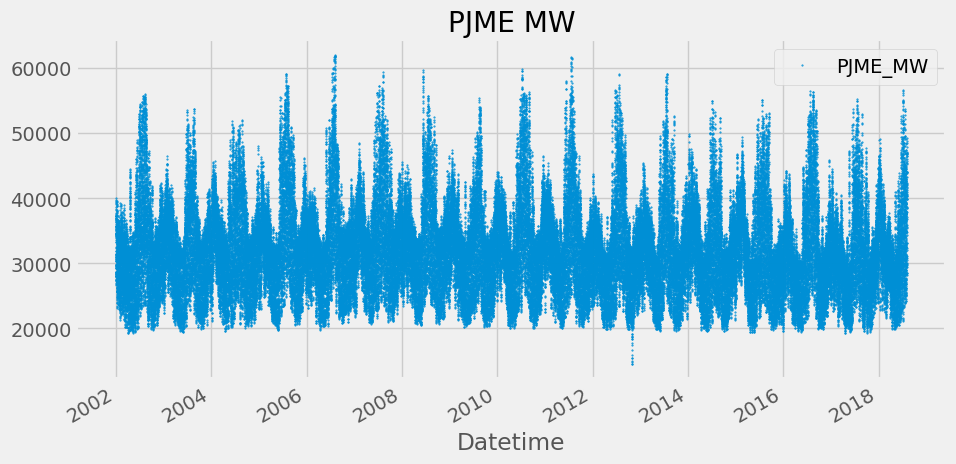

In [7]:
color_pal = sns.color_palette()
pjme.plot(style='.',
          figsize=(10, 5),
          ms=1,
          color=color_pal[0],
          title='PJME MW')
plt.show()

Time Series Features

In [9]:
import pandas as pd
from pandas.api.types import CategoricalDtype

# Define ordered categories for weekdays
cat_type = CategoricalDtype(categories=['Monday', 'Tuesday', 'Wednesday', 
                                        'Thursday', 'Friday', 
                                        'Saturday', 'Sunday'], 
                            ordered=True)

def create_features(df, label=None):
    """
    Creates time series features from datetime index.
    """
    df = df.copy()
    df['date'] = df.index
    df['hour'] = df['date'].dt.hour
    df['dayofweek'] = df['date'].dt.dayofweek
    df['weekday'] = df['date'].dt.day_name().astype(cat_type)
    df['quarter'] = df['date'].dt.quarter
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year
    df['dayofyear'] = df['date'].dt.dayofyear
    df['dayofmonth'] = df['date'].dt.day
    df['weekofyear'] = df['date'].dt.isocalendar().week  # Updated for deprecation

    # Define seasons directly by month ranges
    df['season'] = pd.cut(
        df['month'], 
        bins=[0, 3, 6, 9, 12], 
        labels=['Winter', 'Spring', 'Summer', 'Fall'], 
        right=False
    )

    # Select features for the model
    X = df[['hour', 'dayofweek', 'quarter', 'month', 'year',
            'dayofyear', 'dayofmonth', 'weekofyear', 'weekday', 'season']]
    
    if label:
        if label in df.columns:  # Check if the label column exists
            y = df[label]
            return X, y
        else:
            raise ValueError(f"Label '{label}' not found in the DataFrame.")
    
    return X

# Example usage
X, y = create_features(pjme, label='PJME_MW')
features_and_target = pd.concat([X, y], axis=1)



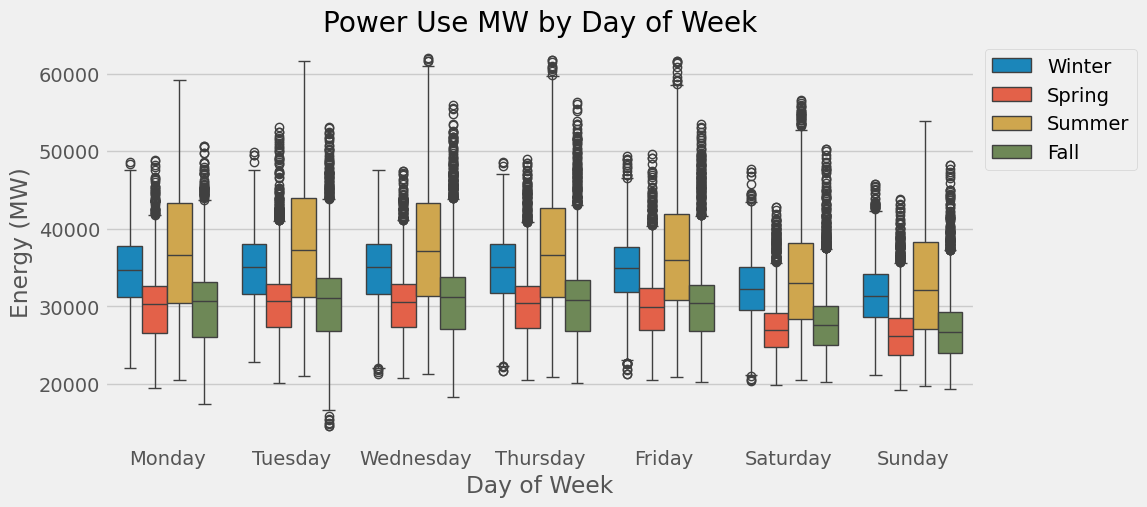

In [10]:
fig, ax = plt.subplots(figsize=(10, 5))
sns.boxplot(data=features_and_target.dropna(),
            x='weekday',
            y='PJME_MW',
            hue='season',
            ax=ax,
            linewidth=1)
ax.set_title('Power Use MW by Day of Week')
ax.set_xlabel('Day of Week')
ax.set_ylabel('Energy (MW)')
ax.legend(bbox_to_anchor=(1, 1))
plt.show()

Train / Test Split

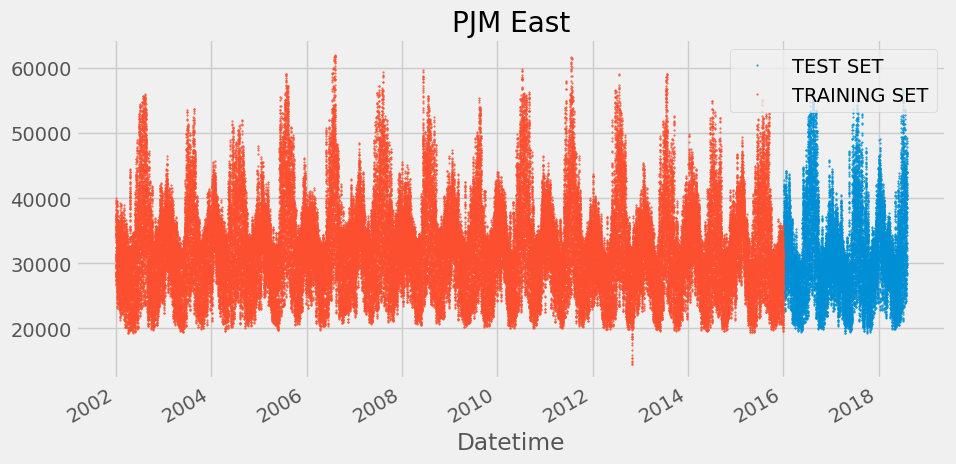

In [11]:
split_date = '1-Jan-2016'
pjme_train = pjme.loc[pjme.index <= split_date].copy()
pjme_test = pjme.loc[pjme.index > split_date].copy()


pjme_test \
    .rename(columns={'PJME_MW': 'TEST SET'}) \
    .join(pjme_train.rename(columns={'PJME_MW': 'TRAINING SET'}),
          how='outer') \
    .plot(figsize=(10, 5), title='PJM East', style='.', ms=1)
plt.show()

Prophet model expects the dataset to be named a specific way. We will rename our dataframe columns before feeding it into the model.

Datetime column named: ds

target : y

In [12]:
# Format data for prophet model using ds and y
pjme_train_prophet = pjme_train.reset_index() \
    .rename(columns={'Datetime':'ds',
                     'PJME_MW':'y'})

In [13]:
model = Prophet()
model.fit(pjme_train_prophet)

22:59:00 - cmdstanpy - INFO - Chain [1] start processing
23:00:06 - cmdstanpy - INFO - Chain [1] done processing


CPU times: total: 6.02 s
Wall time: 1min 16s


In [14]:
# Predict on test set with model
pjme_test_prophet = pjme_test.reset_index() \
    .rename(columns={'Datetime':'ds',
                     'PJME_MW':'y'})

pjme_test_fcst = model.predict(pjme_test_prophet)

In [15]:
pjme_test_fcst.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2016-01-01 01:00:00,31225.650328,23181.371707,32969.043197,31225.650328,31225.650328,-3233.742681,-3233.742681,-3233.742681,-4410.511837,...,924.239890,924.239890,924.239890,252.529266,252.529266,252.529266,0.0,0.0,0.0,27991.907648
1,2016-01-01 02:00:00,31225.619494,21946.342551,31031.851186,31225.619494,31225.619494,-4734.368429,-4734.368429,-4734.368429,-5899.553049,...,910.194414,910.194414,910.194414,254.990207,254.990207,254.990207,0.0,0.0,0.0,26491.251065
2,2016-01-01 03:00:00,31225.588659,21012.510324,30049.763851,31225.588659,31225.588659,-5606.567886,-5606.567886,-5606.567886,-6758.825372,...,894.765859,894.765859,894.765859,257.491627,257.491627,257.491627,0.0,0.0,0.0,25619.020774
3,2016-01-01 04:00:00,31225.557825,20913.397813,29997.659601,31225.557825,31225.557825,-5751.296892,-5751.296892,-5751.296892,-6888.946287,...,877.615873,877.615873,877.615873,260.033522,260.033522,260.033522,0.0,0.0,0.0,25474.260933
4,2016-01-01 05:00:00,31225.526990,21433.231405,30294.997590,31225.526990,31225.526990,-5082.694617,-5082.694617,-5082.694617,-6203.699509,...,858.389006,858.389006,858.389006,262.615886,262.615886,262.615886,0.0,0.0,0.0,26142.832374


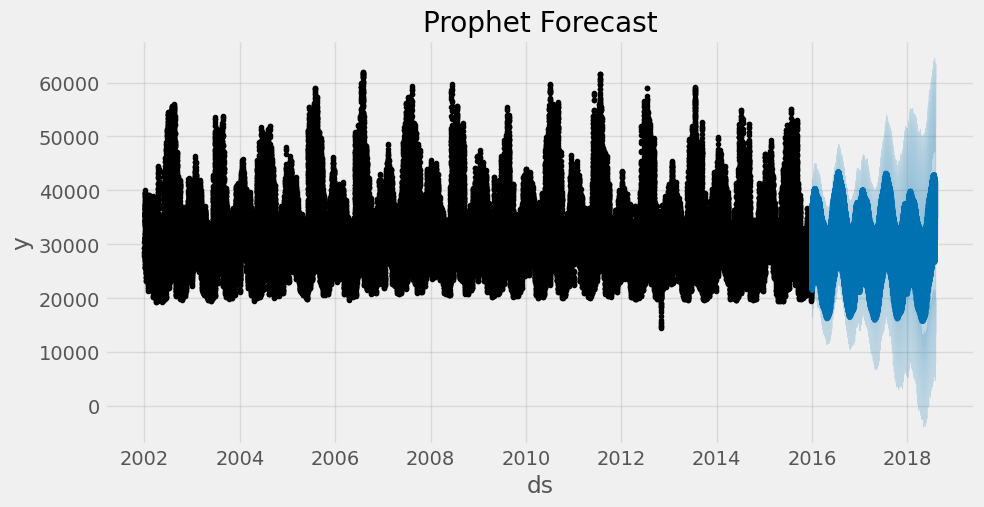

In [16]:
fig, ax = plt.subplots(figsize=(10, 5))
fig = model.plot(pjme_test_fcst, ax=ax)
ax.set_title('Prophet Forecast')
plt.show()

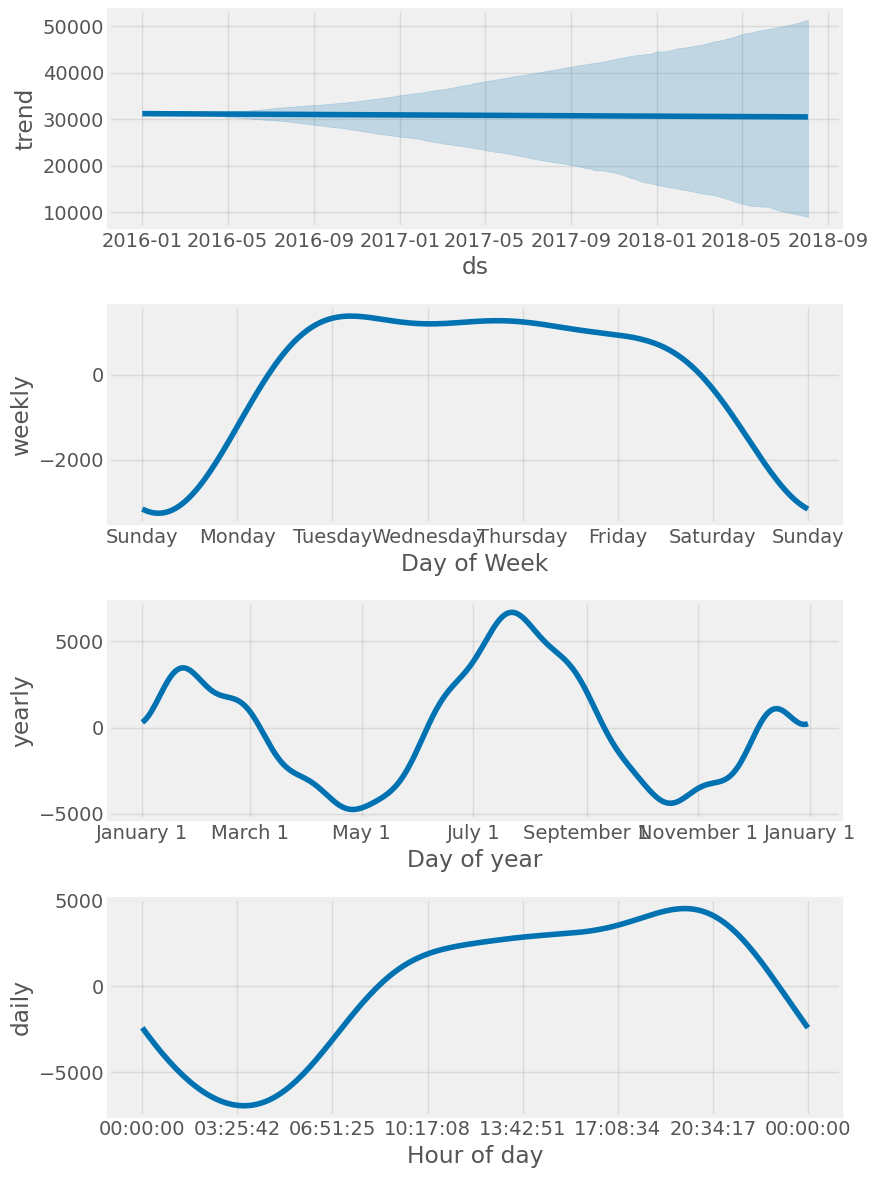

In [17]:
fig = model.plot_components(pjme_test_fcst)
plt.show()

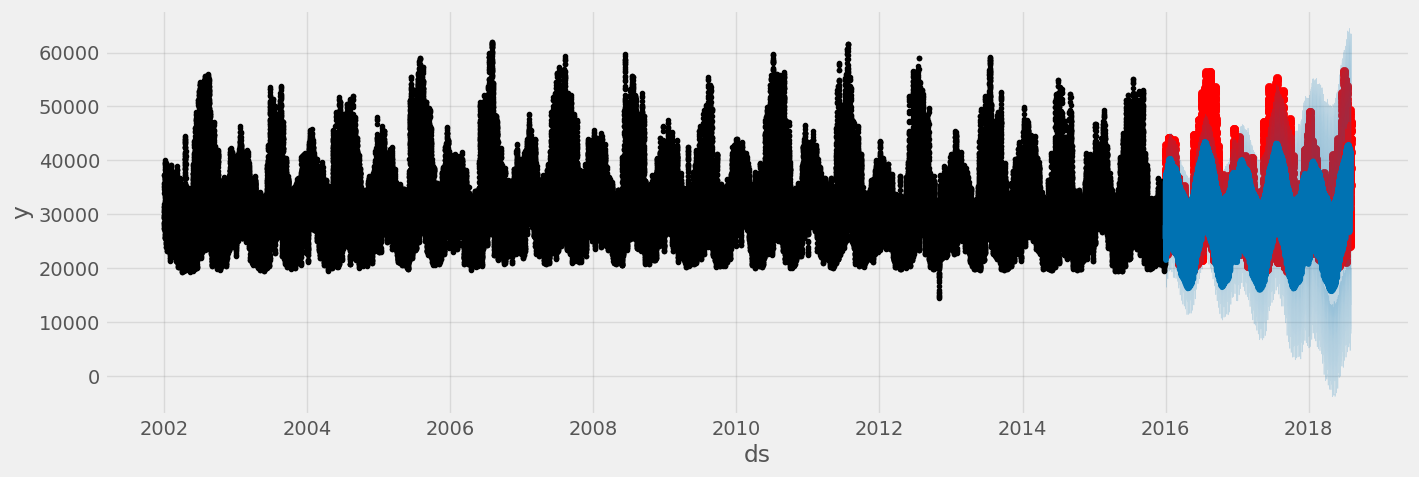

In [18]:
# Plotting the forecast with the actuals
f, ax = plt.subplots(figsize=(15, 5))
ax.scatter(pjme_test.index, pjme_test['PJME_MW'], color='r')
fig = model.plot(pjme_test_fcst, ax=ax)

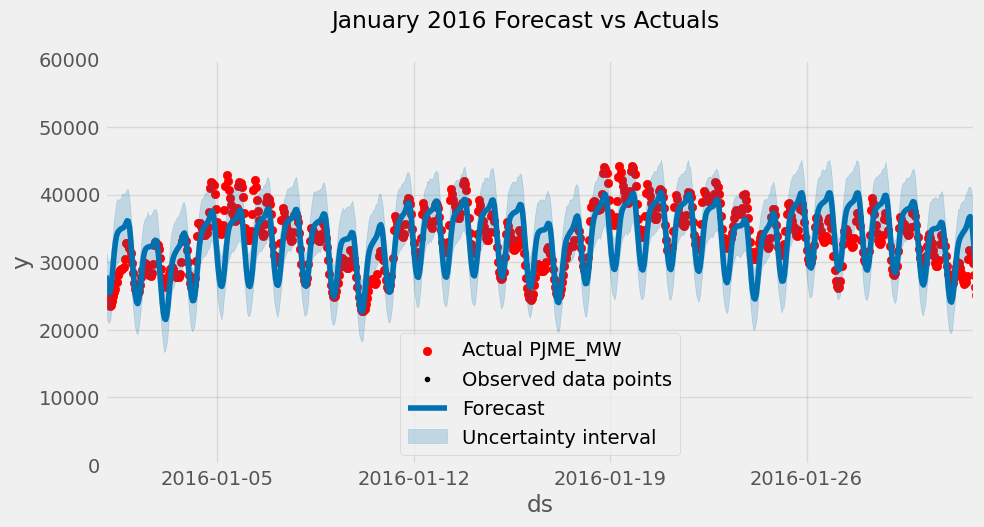

In [21]:
fig, ax = plt.subplots(figsize=(10, 5))

# Plot actual values as red scatter points
ax.scatter(pjme_test.index, pjme_test['PJME_MW'], color='r', label='Actual PJME_MW')

# Plot the Prophet forecast
fig = model.plot(pjme_test_fcst, ax=ax)

# Set x-axis bounds for the specific date range in January 2016
ax.set_xlim(pd.Timestamp('2016-01-01'), pd.Timestamp('2016-02-01'))

# Set y-axis limits
ax.set_ylim(0, 60000)

# Set the title for the plot
plt.suptitle('January 2016 Forecast vs Actuals')

# Add a legend for clarity
ax.legend()
plt.show()


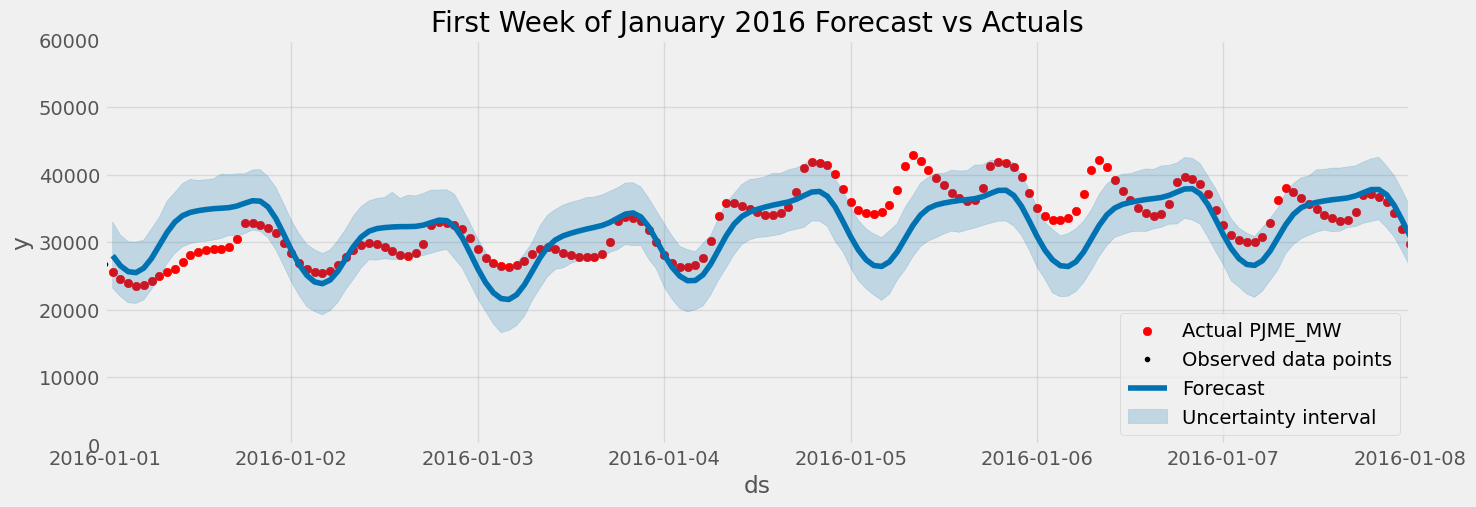

In [22]:
import pandas as pd
import matplotlib.pyplot as plt

# Plot the forecast with the actuals
f, ax = plt.subplots(figsize=(15, 5))

# Plot actual values as red scatter points
ax.scatter(pjme_test.index, pjme_test['PJME_MW'], color='r', label='Actual PJME_MW')

# Plot the Prophet forecast
fig = model.plot(pjme_test_fcst, ax=ax)

# Set x-axis bounds for the first week of January 2016
ax.set_xlim(pd.Timestamp('2016-01-01'), pd.Timestamp('2016-01-08'))

# Set y-axis limits
ax.set_ylim(0, 60000)

# Set the title for the plot
ax.set_title('First Week of January 2016 Forecast vs Actuals')

# Add a legend for clarity
ax.legend()

# Display the plot
plt.show()


Evaluating the model with Error Metrics

In [23]:
np.sqrt(mean_squared_error(y_true=pjme_test['PJME_MW'],
                   y_pred=pjme_test_fcst['yhat']))

6306.941735811532

In [24]:
mean_absolute_error(y_true=pjme_test['PJME_MW'],
                   y_pred=pjme_test_fcst['yhat'])

4919.507067337571

In [25]:
mean_absolute_percentage_error(y_true=pjme_test['PJME_MW'],
                   y_pred=pjme_test_fcst['yhat'])

15.842960604712339

Adding Holidays

Next we will see if adding holiday indicators will help the accuracy of the model. Prophet comes with a Holiday Effects parameter that can be provided to the model prior to training.


We will use the built in pandas USFederalHolidayCalendar to pull the list of holidays

In [26]:
from pandas.tseries.holiday import USFederalHolidayCalendar as calendar

cal = calendar()


holidays = cal.holidays(start=pjme.index.min(),
                        end=pjme.index.max(),
                        return_name=True)
holiday_df = pd.DataFrame(data=holidays,
                          columns=['holiday'])
holiday_df = holiday_df.reset_index().rename(columns={'index':'ds'})

In [27]:
model_with_holidays = Prophet(holidays=holiday_df)
model_with_holidays.fit(pjme_train_prophet)

23:07:56 - cmdstanpy - INFO - Chain [1] start processing
23:09:08 - cmdstanpy - INFO - Chain [1] done processing


In [28]:
# Predict on training set with model
pjme_test_fcst_with_hols = \
    model_with_holidays.predict(df=pjme_test_prophet)

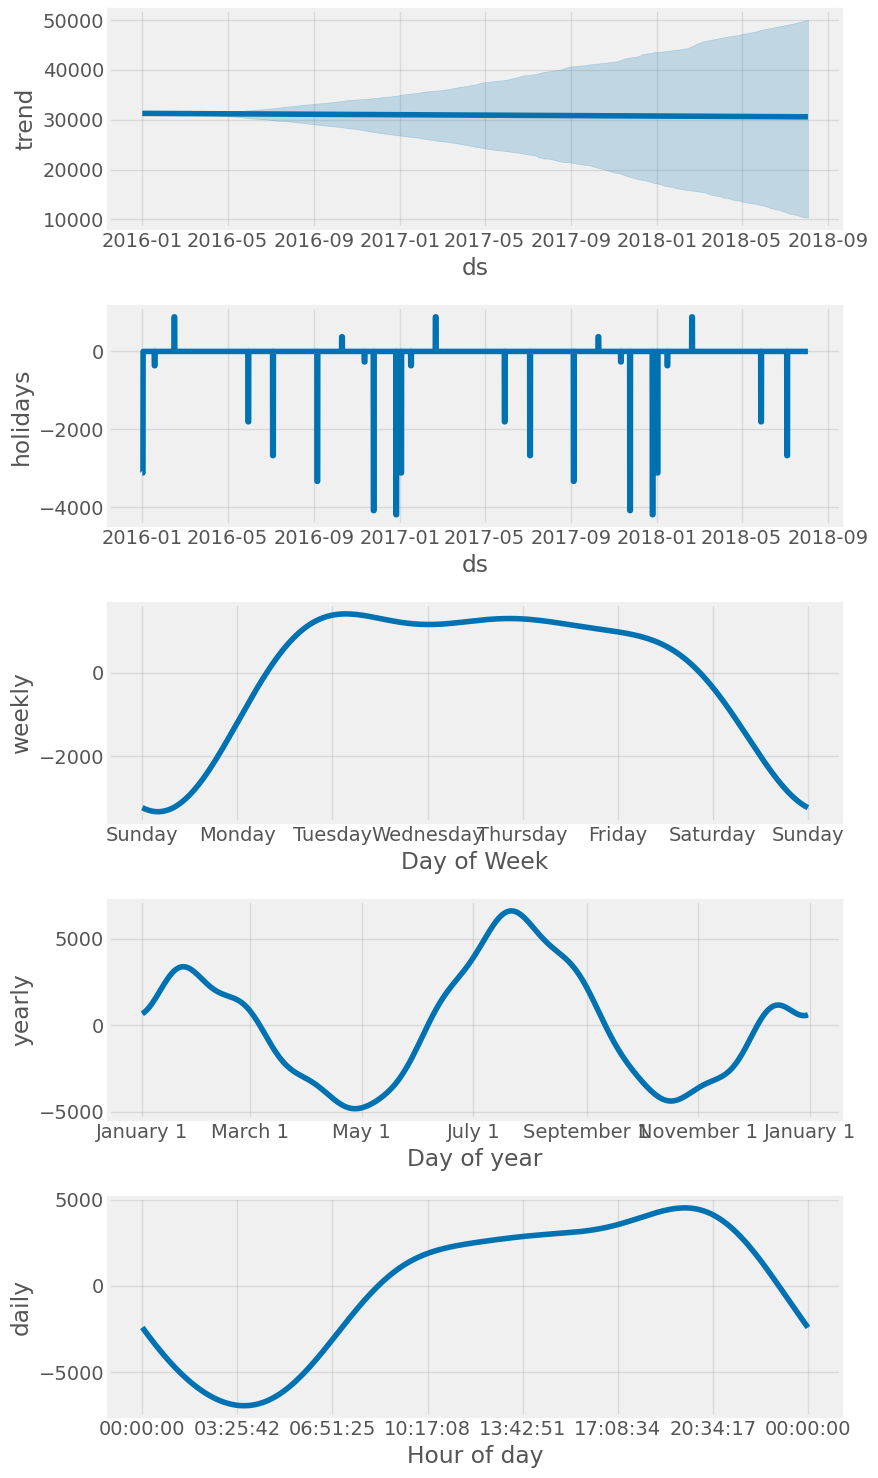

In [29]:
fig = model_with_holidays.plot_components(
    pjme_test_fcst_with_hols)
plt.show()

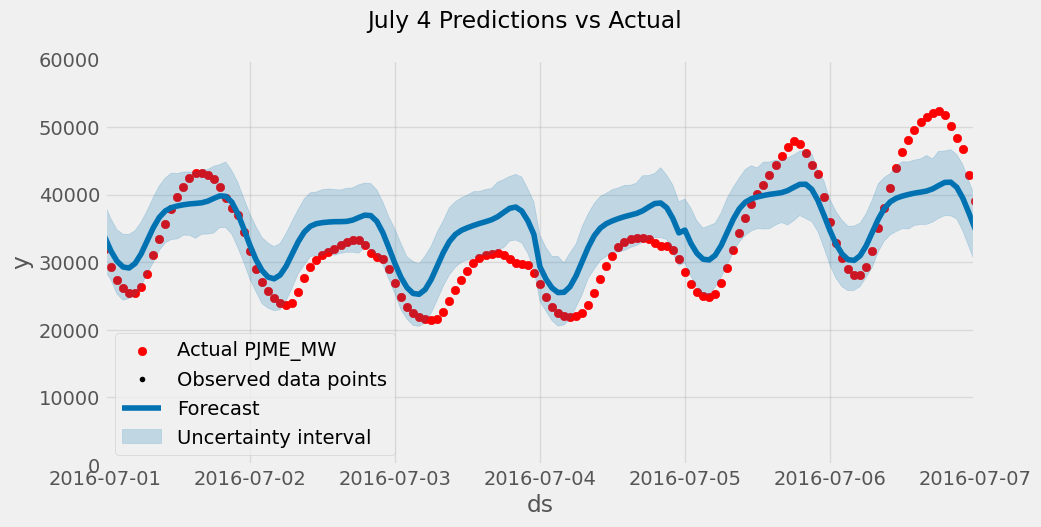

In [30]:
import pandas as pd
import matplotlib.pyplot as plt

# Plot the forecast with the actuals
fig, ax = plt.subplots(figsize=(10, 5))

# Plot actual values as red scatter points
ax.scatter(pjme_test.index, pjme_test['PJME_MW'], color='r', label='Actual PJME_MW')

# Plot the Prophet forecast with holidays (assuming 'pjme_test_fcst_with_hols' is the correct forecast DataFrame)
fig = model.plot(pjme_test_fcst_with_hols, ax=ax)

# Set x-axis bounds for the specific date range in July 2016
ax.set_xlim(pd.Timestamp('2016-07-01'), pd.Timestamp('2016-07-07'))

# Set y-axis limits
ax.set_ylim(0, 60000)

# Set the title for the plot
plt.suptitle('July 4 Predictions vs Actual')

# Add a legend for clarity
ax.legend()

# Display the plot
plt.show()


In [31]:
np.sqrt(mean_squared_error(y_true=pjme_test['PJME_MW'],
                   y_pred=pjme_test_fcst_with_hols['yhat']))

6326.479510211952

In [32]:
mean_absolute_error(y_true=pjme_test['PJME_MW'],
                   y_pred=pjme_test_fcst_with_hols['yhat'])

4936.718196636556

In [33]:
mean_absolute_percentage_error(y_true=pjme_test['PJME_MW'],
                   y_pred=pjme_test_fcst_with_hols['yhat'])

15.902163282196888

Predict into the Future

In [34]:
future = model.make_future_dataframe(periods=365*24, freq='h', include_history=False)
forecast = model_with_holidays.predict(future)

In [35]:
forecast[['ds','yhat']].head()

,ds,yhat
0,2016-01-01 01:00:00,25319.751639
1,2016-01-01 02:00:00,23815.943799
2,2016-01-01 03:00:00,22940.618367
3,2016-01-01 04:00:00,22792.881972
4,2016-01-01 05:00:00,23458.547362
